# VGG

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

## VGG block

In [2]:
def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    x = input_layer

    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            kernel_regularizer=keras.regularizers.l2(5e-4),
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [3]:
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

## VGG-16

In [4]:
vgg_16 = build_vgg(input_shape=(224,224,3))
vgg_16.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)      

## VGG-19

In [5]:
vgg_19 = build_vgg(
    input_shape=(224,224,3),
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)
vgg_19.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)      

## Dataset (CIFAR-10)

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [7]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [8]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [9]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224)) # resize
    image = tf.cast(image, tf.float32) / 255.

    return image, label

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
ds_info.features["label"].num_classes

10

In [12]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

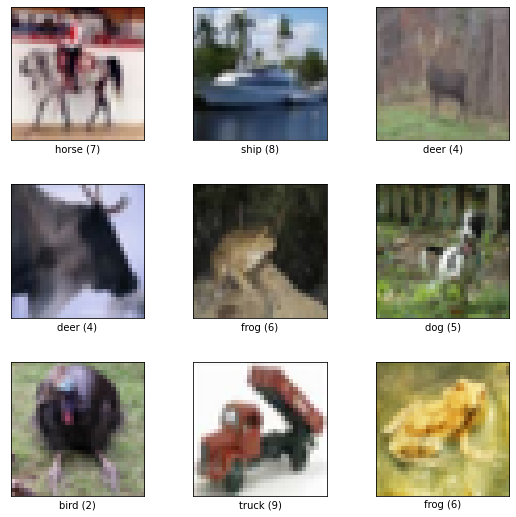

In [13]:
fig = tfds.show_examples(ds_train, ds_info)

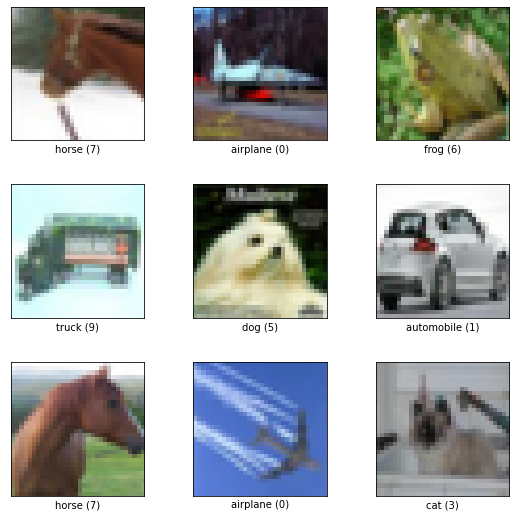

In [14]:
fig = tfds.show_examples(ds_test, ds_info)

## VGG-16 vs VGG-19

In [15]:
BATCH_SIZE = 32 #256
iteration = 25000 #600000
EPOCH = iteration*BATCH_SIZE//int(ds_info.splits['train'].num_examples)

In [16]:
EPOCH

16

In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [18]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.01, patience=1, verbose=1, min_lr=1e-6)

In [19]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/16
   2/1562 [..............................] - ETA: 4:16 - loss: 7.2945 - accuracy: 0.0938WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0945s vs `on_train_batch_end` time: 0.2338s). Check your callbacks.


1562/1562 [==============================] - 642s 411ms/step - loss: 5.4985 - accuracy: 0.3321 - val_loss: 4.6755 - val_accuracy: 0.4669
Epoch 2/16
1562/1562 [==============================] - 653s 418ms/step - loss: 4.0831 - accuracy: 0.5482 - val_loss: 3.4834 - val_accuracy: 0.6493
Epoch 3/16
1562/1562 [==============================] - 641s 410ms/step - loss: 3.1632 - accuracy: 0.6594 - val_loss: 2.7740 - val_accuracy: 0.7067
Epoch 4/16
1562/1562 [==============================] - 617s 395ms/step - loss: 2.5537 - accuracy: 0.7084 - val_loss: 2.3471 - val_accuracy: 0.7181
Epoch 5/16
1562/1562 [==============================] - 636s 407ms/step - loss: 2.0821 - accuracy: 0.7511 - val_loss: 1.9380 - val_accuracy: 0.7533
Epoch 6/16
1562/1562 [==============================] - 635s 407ms/step - loss: 1.7187 - accuracy: 0.7859 - val_loss: 1.6539 - val_accuracy: 0.7734
Epoch 7/16
1562/1562 [==============================] - 636s 407ms/step - loss: 1.4417 - accuracy: 0.8122 - val_loss: 1.500

In [20]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/16
   2/1562 [..............................] - ETA: 5:05 - loss: 8.4777 - accuracy: 0.1250WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1219s vs `on_train_batch_end` time: 0.2692s). Check your callbacks.


1562/1562 [==============================] - 753s 482ms/step - loss: 6.7670 - accuracy: 0.2690 - val_loss: 5.6903 - val_accuracy: 0.4208
Epoch 2/16
1562/1562 [==============================] - 746s 478ms/step - loss: 5.0498 - accuracy: 0.4790 - val_loss: 4.4211 - val_accuracy: 0.5577
Epoch 3/16
1562/1562 [==============================] - 743s 476ms/step - loss: 3.8652 - accuracy: 0.6097 - val_loss: 3.3518 - val_accuracy: 0.6784
Epoch 4/16
1562/1562 [==============================] - 724s 463ms/step - loss: 3.0888 - accuracy: 0.6691 - val_loss: 2.7448 - val_accuracy: 0.7032
Epoch 5/16
1562/1562 [==============================] - 746s 478ms/step - loss: 2.4983 - accuracy: 0.7115 - val_loss: 2.2631 - val_accuracy: 0.7274
Epoch 6/16
1562/1562 [==============================] - 746s 477ms/step - loss: 2.0484 - accuracy: 0.7455 - val_loss: 1.8981 - val_accuracy: 0.7527
Epoch 7/16
1562/1562 [==============================] - 746s 478ms/step - loss: 1.6932 - accuracy: 0.7754 - val_loss: 1.617

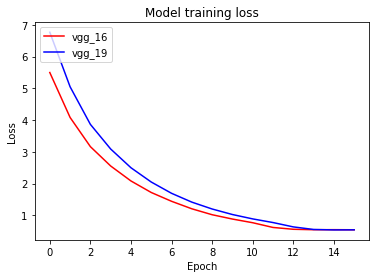

In [21]:
plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

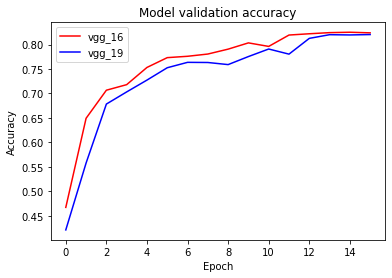

In [22]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()